#Data Loading and Cleaning

In [ ]:
import pandas as pd
train_data = pd.read_csv('/content/drive/MyDrive/meme_classification_data/train.csv')
train_data.head(3)

,ID,image id,text,label,label_num
0,1,image_2455.jpg,- It is not our fight - Are we not part of thi...,troll,2
1,2,image_3701.jpg,THAT'S THE DIFFERENCE BETWEEN YOU AND ME YOU...,none,0
2,3,image_4166.png,- WHAT DO THE TITANIC AND THE SIXTH SENSE HAVE...,none,0


##Contractions

In [ ]:
contractions = {
"ain't": "are not",
"aren't": "are not",
"can't": "can not",
"can't've": "can not have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"i'd": "I would",
"i'd've": "I would have",
"i'll": "I will",
"i'll've": "I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so is",
"that'd": "that had",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

#

In [ ]:
def expand_short_forms(word):
    if(word.lower() in contractions):
        return contractions[word.lower()]
    else:
        return word

import re
def remove_special_chars_except_apostrophe(sentence):
    return re.sub(r"[^\w\d'\s]+",'',sentence.lower())

filter_words = ["meme", "http", "www"]
def filter(text):
    words = text.split()
    filtered_words = []
    for w in words:
        flg = 0
        for fw in filter_words:
            if fw in w:
                flg = 1
                break
            if 'com' in w and len(w) > 7:
                flg = 1
        
        if flg == 0:
            filtered_words.append(w)
        
    sent = " ".join(filtered_words)
    return sent
        
def clean_text(text):
    sent = re.sub(r"[^\w\d'\s]+",'',text.lower()) # remove special chars excecpt apostrophe
    words = sent.split() 
    words_expanded = []
    for w in words:
        if w in contractions:
            words_expanded.append(contractions[w])
        else:
            words_expanded.append(w)
        
    sent = " ".join(words_expanded)
    sent = filter(sent)
            
    return sent
train_data['text'] = train_data['text'].apply(clean_text)
train_data.head(3)

,ID,image id,text,label,label_num
0,1,image_2455.jpg,it is not our fight are we not part of this wo...,troll,2
1,2,image_3701.jpg,that is the difference between you and me you ...,none,0
2,3,image_4166.png,what do the titanic and the sixth sense have i...,none,0


#BERT model for classification

##Loading the Model

In [ ]:
!pip install pytorch-pretrained-bert pytorch-nlp

import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
print(torch.cuda.get_device_name(0))



In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
model.cuda()


##Converting Data into Proper Format For the Model

In [ ]:
train_text = ["[CLS] " + text + " [SEP]" for text in train_data['text'].values]
labels = train_data['label_num'].values
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_train_text = [tokenizer.tokenize(sent) for sent in train_text]

MAX_LEN = 90 # Max word length of text
# Pad our input tokens
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_train_text],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_train_text]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

input_ids.shape, labels.shape

((1991, 90), (1991,))

In [ ]:
# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)
  # Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.2)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.2)
                                             
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# Create an iterator of our data with torch DataLoader 
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


##Training The Model

t_total value of -1 results in schedule not being applied


Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Train loss: 0.4712923139333725




Epoch:  12%|█▎        | 1/8 [00:28<03:20, 28.62s/it]

Validation Accuracy: 0.4116071428571429
Train loss: 0.22804253458976745




Epoch:  25%|██▌       | 2/8 [00:57<02:52, 28.78s/it]

Validation Accuracy: 0.4272321428571429
Train loss: 0.08467204373329879




Epoch:  38%|███▊      | 3/8 [01:27<02:25, 29.01s/it]

Validation Accuracy: 0.40654761904761905
Train loss: 0.05740478053689003




Epoch:  50%|█████     | 4/8 [01:57<01:56, 29.24s/it]

Validation Accuracy: 0.38586309523809526
Train loss: 0.037033951906487346




Epoch:  62%|██████▎   | 5/8 [02:27<01:28, 29.48s/it]

Validation Accuracy: 0.43720238095238095
Train loss: 0.021176764657720924




Epoch:  75%|███████▌  | 6/8 [02:57<00:59, 29.67s/it]

Validation Accuracy: 0.43720238095238095
Train loss: 0.026711873756721616




Epoch:  88%|████████▊ | 7/8 [03:27<00:29, 29.84s/it]

Validation Accuracy: 0.4193452380952381
Train loss: 0.03819572191685438




Epoch: 100%|██████████| 8/8 [03:57<00:00, 29.73s/it]

Validation Accuracy: 0.38303571428571426


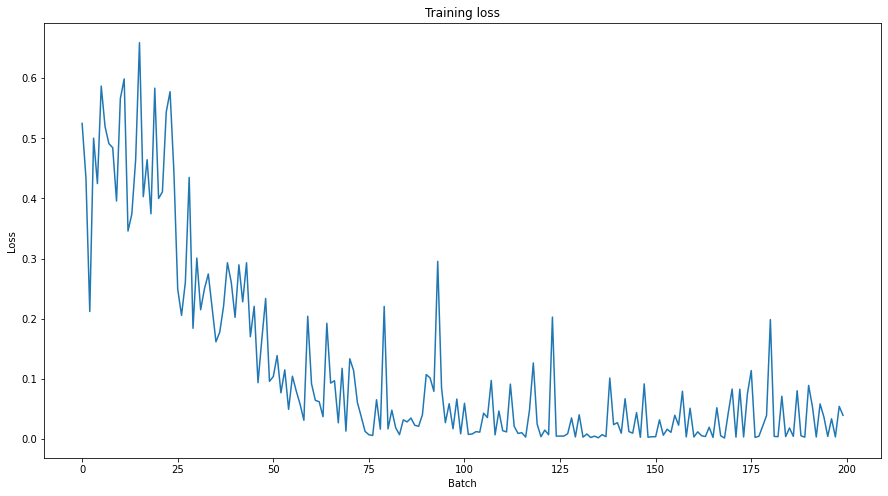

In [ ]:
# Select a batch size for training. 
batch_size = 64

# BERT fine-tuning parameters
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
  
# Store our loss and accuracy for plotting
train_loss_set = []
# Number of training epochs 
epochs = 8

# BERT training loop
for _ in trange(epochs, desc="Epoch"):  
  
  ## TRAINING
  
  # Set our model to training mode
  model.train()  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1
  print("Train loss: {}".format(tr_loss/nb_tr_steps))
       
  ## VALIDATION

  # Put model in evaluation mode
  model.eval()
  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1
  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

# plot training performance
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

##Classification Report On Validation set

In [ ]:
from sklearn.metrics import classification_report

# Put model in evaluation mode
model.eval()
# Tracking variables 
predictions = []
# Predict 
for batch in validation_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
 
  # Store predictions and true labels
  predictions.append(logits)

  

flat_predictions = [item for sublist in predictions for item in sublist]
y_pred = np.argmax(flat_predictions, axis=1).flatten()
y_true = validation_labels.detach().cpu().numpy()


print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.31      0.46      0.37       116
           1       0.44      0.26      0.33       135
           2       0.43      0.43      0.43       148

    accuracy                           0.38       399
   macro avg       0.39      0.38      0.38       399
weighted avg       0.40      0.38      0.38       399

